# Dataset

In [85]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# data
irf = 'z20'
table = 'regressor_5sgm_exp30m_z20_xy_flip.pickle'
path = f'/home/dipiano/E4/irf_{irf}/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
    gammatable = join(path, table.replace('.pickle', '_gammapy.txt'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))
    gammatable = join(path, table.replace('.npy', '_gammapy.txt'))
    
ds = np.array(ds['DS'])
ds = ds.reshape(ds.shape[0], ds.shape[1], ds.shape[2], 1)
ds.shape

(20000, 200, 200, 1)

# Info table

In [86]:
infodata = pd.read_csv(infofile, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
12000,crab_00001,1,0,100,100,244.586146,44.399571,246.427705,44.675062,1.341217,North_z20_N_0.5h_LST,2.5,7.359504
12001,crab_00002,2,0,100,100,236.928863,47.580359,239.178954,48.055799,1.583875,North_z40_N_0.5h_LST,2.5,7.260205
12002,crab_00003,3,0,100,100,177.604276,61.172610,179.962656,60.470637,1.347013,North_z20_N_0.5h_LST,2.5,7.382857
12003,crab_00004,4,0,100,100,242.226627,51.370683,240.935740,51.904333,0.962607,North_z20_S_0.5h_LST,2.5,7.401701
12004,crab_00005,5,0,100,100,64.798566,57.811073,62.515089,57.420957,1.283648,North_z40_N_0.5h_LST,2.5,7.275704


# Gamma table

In [87]:
gammadata = pd.read_csv(gammatable, sep=' ', header=0).sort_values(by=['seed'])
gammadata.head()

,seed,loc_ra,loc_dec,counts_on,counts_off,excess,excess_err,sigma,correct_irf,selected_irf
0,8001,160.074066,5.495648,NaN,NaN,NaN,NaN,NaN,North_z20_S_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
1,8002,288.501191,10.680641,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
2,8003,243.508483,80.010392,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
3,8004,181.084998,73.805329,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...
4,8005,237.250146,-79.382836,NaN,NaN,NaN,NaN,NaN,North_z20_N_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...


In [88]:
len(gammadata)

2000

# CNN cleaner

In [89]:
import tensorflow as tf

root = '/home/dipiano/astroAI/astroai/'
cnnname = 'cleaner_FINAL_5sgm_filter12_expRAND'
model = tf.keras.models.load_model(join(root, 'models/cnn_cleaner', f'{cnnname}.keras'))
predictions = model.predict(ds)

625/625 [==============================] - 22s 35ms/step


In [90]:
len(predictions)

20000

# CNN regressor

In [91]:
import tensorflow as tf

savename = 'regressor_FINAL_5sgm_filter6_4convs_z20_xy_flip' 
model = tf.keras.models.load_model(f'../models/cnn_regressor/{savename}.keras')
candidates = model.predict(predictions) * binning

625/625 [==============================] - 32s 50ms/step


In [92]:
len(candidates)

20000

# Seed

In [93]:
idx = 8000 + np.random.choice(range(len(gammadata)))
# find seed to get the original heatmap
seed = idx + 1
print('Seed:', seed)

Seed: 8526


In [94]:
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
8525,crab_08526,8526,0,100,100,76.770673,40.223161,78.325343,40.05091,1.200953,North_z20_S_0.5h_LST,2.5,7.459119


In [95]:
grow = gammadata[gammadata['seed']==seed]
grow

,seed,loc_ra,loc_dec,counts_on,counts_off,excess,excess_err,sigma,correct_irf,selected_irf
525,8526,321.948787,42.907199,NaN,NaN,NaN,NaN,NaN,North_z20_S_0.5h_LST,/data01/homes/dipiano/caldb/data/cta/prod5/Pro...


# WCS

In [96]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

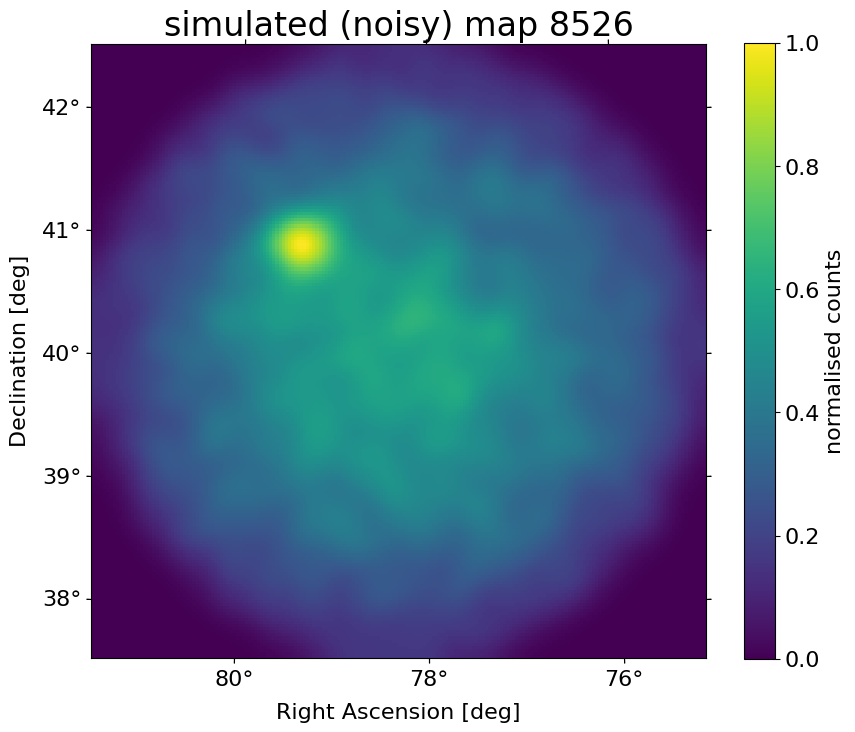

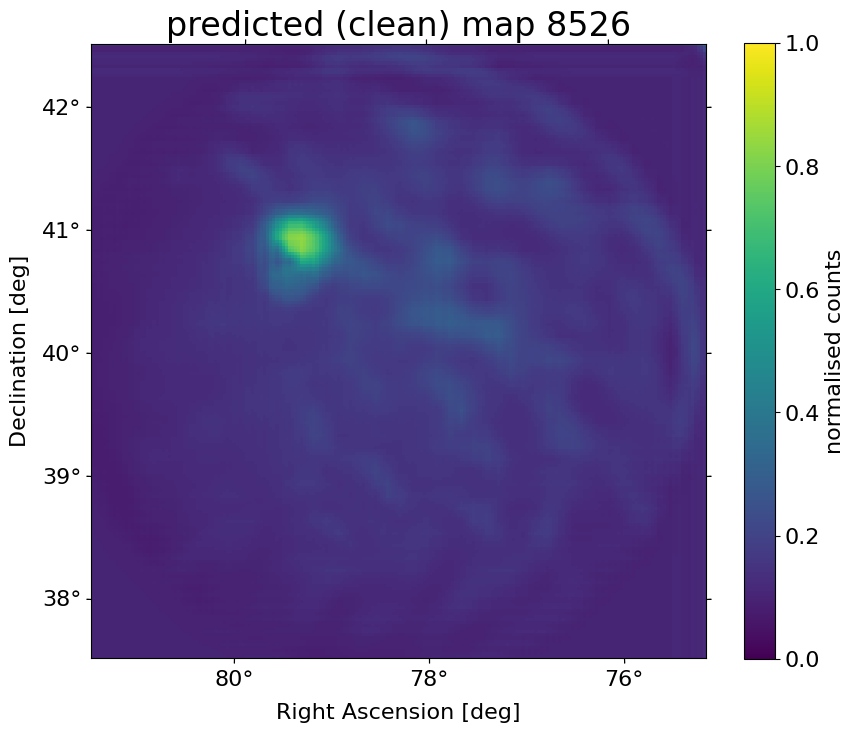

In [100]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (8, 8)
fs = 16

# NOISY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
    
img = ax.imshow(ds[idx], vmin=0, vmax=1)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'simulated (noisy) map {seed}', fontsize=fs*1.5)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.tight_layout()
plt.show()
fig.savefig(f'img/talk_map_{seed}_noisy.png')

# CLEAN
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'predicted (clean) map {seed}', fontsize=fs*1.5)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.tight_layout()
plt.show()
fig.savefig(f'img/talk_map_{seed}_clean.png')

# Find coordinates (pix and sky)

In [98]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# PREDICTION
pred_pix = candidates[idx]
sky = w.pixel_to_world(pred_pix[0], pred_pix[1])
pred_sky = sky.ra.deg, sky.dec.deg

# GAMMAPY
gamma_sky = SkyCoord(ra=grow['loc_ra'].values[0], dec=grow['loc_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(gamma_sky) 
gamma_sky = gamma_sky.ra.deg, gamma_sky.dec.deg
gamma_pix = x, y

print(f'SEED: {seed}')
print('---- PIX')
print(f"true: {true_pix}")
print(f"prediction: {pred_pix}")
print(f"gammapy: {gamma_pix}")
print('---- SKY')
print(f"true: {true_sky} ")
print(f"prediction: {pred_sky}")
print(f"gammapy: {gamma_sky}")

SEED: 8526
---- PIX
true: (array(146.50459618), array(106.32951742))
prediction: [ 77.494446 121.50718 ]
gammapy: (array(3056.35699307), array(1976.2702864))
---- SKY
true: (76.77067336300901, 40.22316108542034) 
prediction: (79.03435281219345, 40.61082190714161)
gammapy: (321.9487866384648, 42.90719938480152)


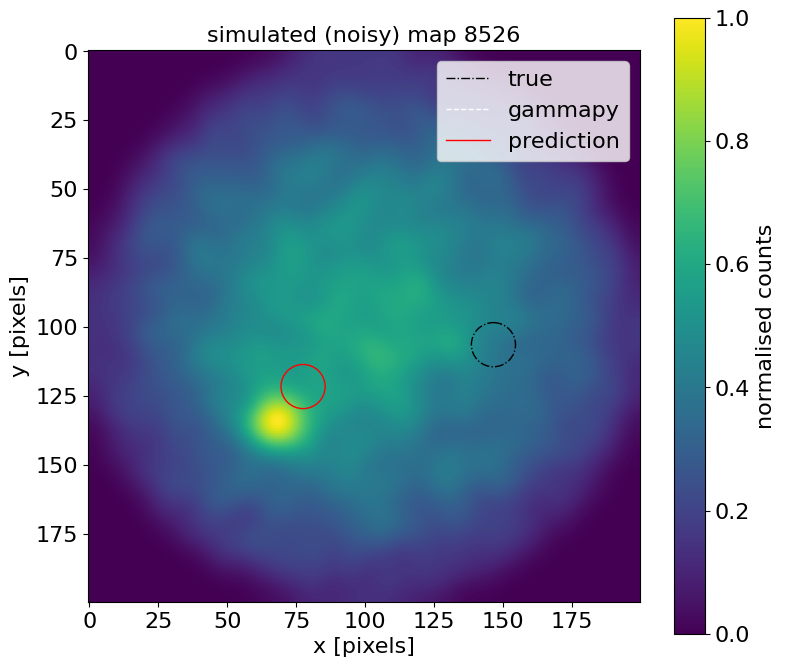

<Figure size 640x480 with 0 Axes>

In [99]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='w', lw=1, ls='--'),
                Line2D([0], [0], color='r', lw=1, ls='-')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.imshow(ds[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.add_patch(plt.Circle((gamma_pix), radius=radius_pix, edgecolor='w', facecolor='none', ls='--'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
ax.set_title(f'simulated (noisy) map {seed}', fontsize=fs)
ax.legend(custom_lines, ['true', 'gammapy', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.tight_layout()
plt.show()

# SKY
ax = fig.add_subplot(111, projection=w)
ax.imshow(ds[idx], vmin=0, vmax=1)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='r', facecolor='none', ls='-')
ax.scatter(gamma_sky[0], gamma_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='w', facecolor='none', ls='--')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'predicted (clean) map {seed}', fontsize=fs)
ax.legend(custom_lines, ['true', 'gammapy', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.tight_layout()
plt.show()